In [2]:
!pip install pandas numpy scikit-learn faker matplotlib seaborn


Evaluating K-Means Clustering:
K-Means - Silhouette Score: 0.2646, Davies-Bouldin Index: 1.2495

Evaluating Agglomerative Clustering:
Agglomerative Clustering - Silhouette Score: 0.1545, Davies-Bouldin Index: 1.3504


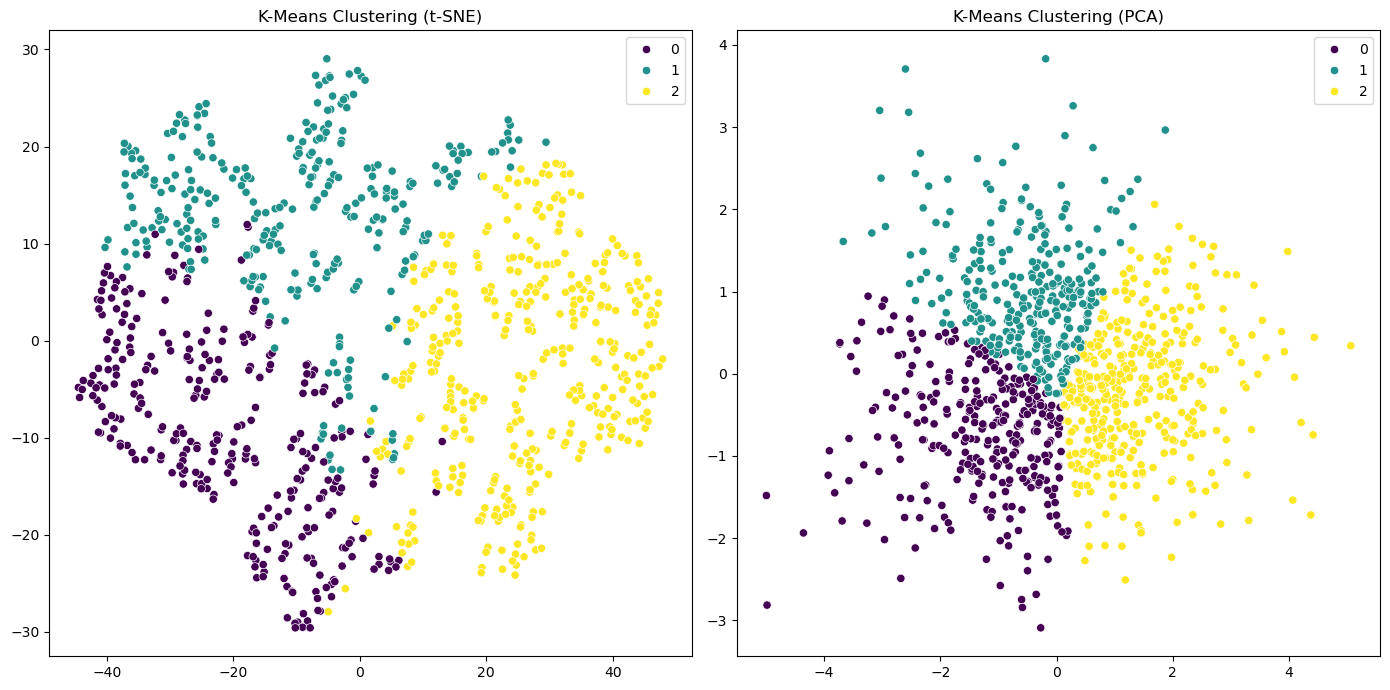

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import datetime

# Generate synthetic transactional data
def generate_transaction_data(num_customers=1000, num_transactions=10000):
    np.random.seed(42)
    customer_ids = [f'C{str(i).zfill(4)}' for i in range(1, num_customers+1)]
    transaction_types = ['deposit', 'withdrawal']
    
    data = []
    for _ in range(num_transactions):
        customer_id = np.random.choice(customer_ids)
        transaction_id = f'T{np.random.randint(1, num_transactions+1):06d}'
        transaction_amount = np.random.uniform(10, 10000)
        transaction_type = np.random.choice(transaction_types)
        transaction_date = datetime.date(2023, np.random.randint(1, 13), np.random.randint(1, 29))
        
        data.append([customer_id, transaction_id, transaction_amount, transaction_type, transaction_date])
    
    columns = ['customer_id', 'transaction_id', 'transaction_amount', 'transaction_type', 'transaction_date']
    df = pd.DataFrame(data, columns=columns)
    return df

# Generate the synthetic dataset
df = generate_transaction_data()

# Data Preprocessing
# Convert categorical variables to numerical using one-hot encoding
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_month'] = df['transaction_date'].dt.month
df['transaction_type'] = df['transaction_type'].map({'deposit': 1, 'withdrawal': 0})

# Aggregate data by customer
agg_df = df.groupby('customer_id').agg({
    'transaction_amount': ['mean', 'sum'],
    'transaction_type': 'sum',
    'transaction_month': 'nunique'
}).reset_index()

agg_df.columns = ['customer_id', 'avg_transaction_amount', 'total_transaction_amount', 'total_deposits', 'unique_transaction_months']

# Feature Scaling
features = agg_df.drop('customer_id', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Define a custom scorer using silhouette_score
def silhouette_scorer_custom(estimator, X):
    labels = estimator.predict(X)  # Get predicted labels from the model
    return silhouette_score(X, labels)  # Compute silhouette score using the predicted labels

# Hyperparameter tuning for K-Means using GridSearchCV with Silhouette Score
kmeans = KMeans(random_state=42)
param_grid = {'n_clusters': [3, 4, 5, 6, 7]}  # You can tune the number of clusters here
grid_search = GridSearchCV(kmeans, param_grid, scoring=silhouette_scorer_custom, cv=5)
grid_search.fit(scaled_features)  # Use scaled_features (or pca_features) based on your previous steps
best_kmeans = grid_search.best_estimator_

# K-Means Clustering with optimal parameters
kmeans_labels = best_kmeans.predict(scaled_features)

# Hyperparameter tuning for Agglomerative Clustering using manual tuning (no GridSearchCV for AgglomerativeClustering)
agglo = AgglomerativeClustering()
param_grid = {'n_clusters': [3, 4, 5, 6, 7]}  # You can tune the number of clusters here
best_agglo = None
best_silhouette = -1
for n_clusters in param_grid['n_clusters']:
    agglo.set_params(n_clusters=n_clusters)
    agglo_labels = agglo.fit_predict(scaled_features)
    silhouette = silhouette_score(scaled_features, agglo_labels)
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_agglo = agglo

# Agglomerative Clustering with optimal parameters
agglo_labels = best_agglo.fit_predict(scaled_features)

# Evaluate Clustering
def evaluate_clustering(labels, features, name="Model"):
    silhouette = silhouette_score(features, labels)
    davies_bouldin = davies_bouldin_score(features, labels)
    print(f"{name} - Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {davies_bouldin:.4f}")
    return silhouette, davies_bouldin

# Evaluate each model
print("\nEvaluating K-Means Clustering:")
evaluate_clustering(kmeans_labels, scaled_features, "K-Means")

print("\nEvaluating Agglomerative Clustering:")
evaluate_clustering(agglo_labels, scaled_features, "Agglomerative Clustering")

# Visualizing Results using PCA and t-SNE
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

# Visualize K-Means Clustering Results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=kmeans_labels, palette='viridis')
plt.title("K-Means Clustering (t-SNE)")

plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=kmeans_labels, palette='viridis')
plt.title("K-Means Clustering (PCA)")

plt.tight_layout()
plt.show()

